#Procedure for processing pilot study data
This notebook describes how the data gathered from the pilot study was processed to prepare it for annotation.

#Obtaining the transcripts
We tested the quality of several models: Microsoft Teams automatic transcription, Voosk (large model integrated into SubtitleEdit), Azure, and Whisper. We selected Whisper due to its low word error rate (\~6% on an initial test), especially considering its accuracy even for words that the model can't have seen in training (e.g., unique variable names). The transcripts were manually revised to ensure that we release a dataset of the highest quality. A few errors were corrected, including a few instances of hallucinations (\~4 lines with repeated phrases). We also adjusted the timestamps, as Whisper's main drawback is that the segmentation is not very precise: many segments included not only the speech, but the surrounding seconds of silence). We used SubtitleEdit for the adjustments.

##Code to obtain the transcripts

In [ ]:
# Install Whisper
!pip install git+https://github.com/openai/whisper.git

Two ways of obtaining the output:

In [ ]:
# Through Python code, exporting to a file
import whisper

model = whisper.load_model("base")
result = model.transcribe("dz.wav")
print(result["text"], file=open("OUTPUT FILE.txt", "w"))

In [ ]:
# Through the terminal. This generates output in json, tsv and srt format.
# We used this method to obtain srt files, which are easily modified in SubtitleEdit.
!whisper 'AUDIO FILE.wav' --language en --model large

##Preprocessing the transcripts
For easier processing, we removed two types of lines from the srt files generated by Whisper, after revising the transcripts: subtitle numbers and blank lines. We used Notepad++ for this:
<ul>
<li>Line operations option to remove blank lines</li>
<li>Regex to find and remove subtitle numbers: ^\d{1,3}\$ --> replace with blank</li>
</ul>
<p> We also double checked that all subtitles were in single lines, so that the final final alternated lines with timestamps and lines with subtitles. We used the reged "[a-z.,]$\r\n[a-z\.,]" to find newline characters that we had missed in SubtitleEdit, and removed them manually.</p>

#Obtaining the speaker labels
The transcription model, while very good at speech to text, did not include speaker recognition. Therefore, we needed to use a separate diarization model to automate the assignment of speaker labels. We tried the [pyannote diarization model](https://huggingface.co/pyannote/speaker-diarization) and were satisfied with the results on an initial test. The model only struggled with non-word sounds (e.g., laughter, sighs, coughing, etc.), which were labeled as a new speaker. There was also one instance of the model mistaking the researcher for a participant (same gender, similar age). One issue that we encountered is that the diarization model segments the dialogue differently from the transcription model. For instance, when there is overlap, the diarization model will generate more segments, trying to separate the spakers; the transcription model, on the other hand, may ignore ignore the less audible speaker, or merge both speakers' speech into one utterance if the second speaker did not say enough distinguishable words to warrant a separate segment.<br/>
Therefore, we may consider alternative ways of assigning speaker labels:
<ul>
<li>Manual labelling: too time-consuming.</li>
<li>Alternative ASR that includes diarization: while this might improve the speaker label accuracy, it could increase the word error rate.</li>
<li>Recording speakers separately: this would require both speakers using microphones, as well as a tool to record the meeting audio from the microphones instead of the output channel; this tool would need to output an absolute timestamp with the recording, in order to synchronize both speakers' files. In a truly remote setting, we would also need to ask speakers about their computer clocktime before the meeting, lest they turn out to be in different timezones.</li>
</ul>

Below is the code used to obtain the diarization files, taken from the huggingface website. The output is an rttm file that shows the timestamps in seconds, following the format: <br/>
SPEAKER FILE 1 0.498 10.041 <NA> <NA> SPEAKER_00 <NA> <NA>

In [ ]:
#From: https://huggingface.co/pyannote/speaker-diarization
from pyannote.audio import Pipeline

pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2.1",
                                    use_auth_token="INSERT YOUR HUGGINGFACE TOKEN")
# Make sure to accept Huggingface's terms and conditions for the token to be valid (tokens may be generated before they are valdated)

# Apply the pipeline to an audio file
diarization = pipeline('SESSION AUDIO.wav')

# Dump the diarization output to disk using RTTM format
with open("SESSION AUDIO.rttm", "w") as rttm:
    diarization.write_rttm(rttm)

##Preprocessing the rttm files
We used Notepad++ to remove unnecessary columns from the file (filename, NA labels). After comparing the output with the audio file, we also changed the automatic speaker labels into our own speaker code numbers. Each file thus has two speaker code numbers, one RESEARCHER label, and one OTHER label (for non-word segments, which are normally not assigned to any particular speaker).

#Creating the json files
We combined our data sources into single json files for easier processing. The file sturcutre is as follows:
<ul>
<li>SESSION object</li>
  <ul>
  <li>Session ID label</li>
  <li>TURNS object, containing a list of TURN objects. Each TURN is a dicitonary with several possible objects:</li>
    <ul>
    <li>TRANSCRIPT</li>
    <li>TIME object, with a dictionary containing a START and END key</li>
    <li>DIARIZATION object, with a dictionary containing a RTTM_START, RTTM_END and SPEAKER label</li>
    <li>KEYLOGS, containing a list of KEYLOG strings</li>
    <li>CODE ENTRIES object, containing a list of dictionaries; each of those is a code entry with the keys: TIME, FILE, CODE and TREE</li>
    </ul>
  </ul>
</ul>


We create the initial structure of the json file from the srt transcription file created by the Whisper model, which we then edited. We used the function below:

In [ ]:
#Function to take srt file and create json with:
#session id
    #turn objects with turn ID
        #transcript objects within the turns
        #time objects within the turns
            #start and end times within the time objects

def create_annotation_json(srtfilename, srt_filepath):
    import json #to create json files
    import re #to use regular expression to find information in strings

    #Extract session id from srt filename using regex
    session_id = re.search('(0\d\d[_&]0\d\d)', srtfilename).group(1)

    #Create json object
    annotation_json = {
        "SESSION": {
            "sessionID": session_id,
            "TURNS": []
            }
    }

    #Iteate through srt file
    with open(srt_filepath, "r") as file:
        #Select turns object as location to add each turn
        turns = annotation_json['SESSION']['TURNS']

        #Read srt lines
        lines = file.readlines()
        #Read lines two by two, as first of pair is timestamps, and second of pair is subtitle string
        for line1, line2 in zip(lines[::2], lines[1::2]):

            #Extract transcript
            transcript = line2

            #Extract timestamps; the line looks like this: 00:01:02,000 --> 00:01:05,000
            start_time = re.search('((\d\d:\d\d:\d\d,\d\d\d) --> (\d\d:\d\d:\d\d,\d\d\d))', line1).group(2)
            end_time = re.search('((\d\d:\d\d:\d\d,\d\d\d) --> (\d\d:\d\d:\d\d,\d\d\d))', line1).group(3)

            #Add TURN object to file
            turns.append({
            "TURN": {
                "TRANSCRIPT": transcript,
                "TIME": {"START": start_time, "END": end_time}
                }
            })

        #Create output filename
        json_filename = srtfilename.strip("srt") + "json"
        #Print output to a json file
        print(json.dumps(annotation_json, indent=4), file=open(json_filename, "+a"))
        print('Generated json file: ' + json_filename)

The initial structure looks like this example of two turns:<br/>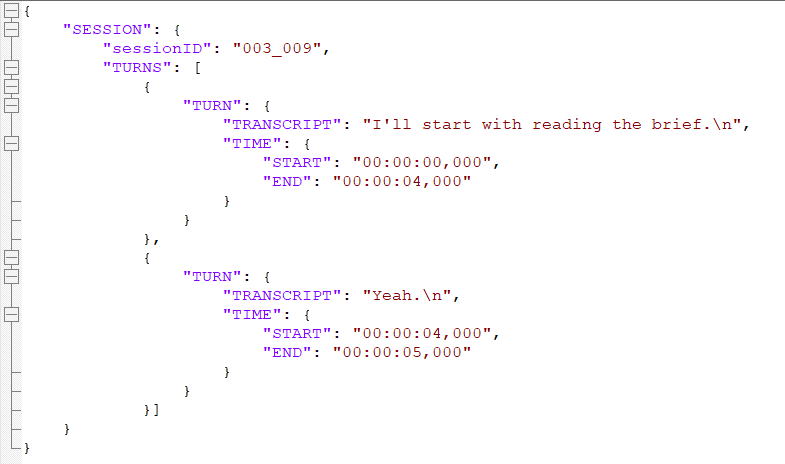

#Adding speaker labels
We used the [pyannote diarization model](https://huggingface.co/pyannote/speaker-diarization) to automatically obtain speaker labels. The model outputs results in an rttm file.<br/>
We edited the files on Notepad++ as described above. We then used them to add speaker labels to the json files with the scripts below, which:
- Convert the timestamps from seconds into minutes and seconds.
- Convert them into the same format as the Whisper srt timestamps.
- Convert timestamps to datetime objects in order to compare them (i.e., see which time comes before which, instead of treating them as strings).
- Extract the timestampts from the rttm file to perform these transfromations.
- Compare rttm and srt timestamps to see which turn from the rttm file was closest to each srt turn. The transcription and diarization models did not segment the dialogues the exact same way, so we needed to compare the turns to find the closest and attach the speaker label from that one.
- Add the speaker label to each turn of the json file. We also add the timestamps from the diarization for easier inspection.

##Convert to minutes and seconds

In [ ]:
#FUNCTION TO CONVERT TIMESTAMPS TO MINUTES AND SECONDS

#Example of initial format:
#SPEAKER 003&009_audio_bleeped 1 1.898 2.312 <NA> <NA> SPEAKER_003 <NA> <NA>

#Example of final format:
#Start: 00:01, End: 00:04, Speaker: 003

#Mini-function to convert time to minutes and seconds
def convert_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02d}:{seconds:02d}"

#----------
# MAIN
#----------
def convert_time_to_mins_in_file(rttm_filepath):
  with open(filename, "r") as file:
    for line in file:
      parts = line.strip().split() #Dividing the line of the rttm file into its components. Timestamp is parts 3 and 4, speaker label is part 7
      start_time = float(parts[3])
      end_time = start_time + float(parts[4])
      speaker_code = parts[7]

      #Apply time conversion function
      formatted_start = convert_time(start_time)
      formatted_end = convert_time(end_time)

      #Print output to file
      output_filename = rttm_filepath[:-5] + "_formatted.rttm"
      print(f"Start: {formatted_start}, End: {formatted_end}, Speaker: {speaker_code}", file=open(output_filename, "a"))


##Convert rttm timestamps to srt format

In [ ]:
#FUNCTION TO CONVERT RTTM TIMESTAMPS INTO SRT TIMESTAMP FORMAT STRINGS
def convert_rttm_timestamps_to_srt_timestamps(rttm_timestamp):
  from datetime import datetime, timedelta #For converting timestamp format and operating with timestamps

  # Parse the input timestamp to get minutes and seconds
  minutes, seconds = map(int, rttm_timestamp.split(":"))

  # Create a timedelta representing the given minutes and seconds
  time_delta = timedelta(minutes=minutes, seconds=seconds)

  # Create a reference datetime with zero hours
  reference_time = datetime.strptime("00:00:00", "%H:%M:%S")

  # Add the timedelta to the reference time to get the new time
  new_time = reference_time + time_delta

  # Format the new time as "hours:minutes:seconds,milliseconds"
  formatted_new_time = new_time.strftime("%H:%M:%S,%f")[:-3]  # Truncate to milliseconds
  return formatted_new_time

##Convert timestamp strings into datetime objects

In [ ]:
#FUNCTION TO CONVERT TIMESTAMP STRINGS INTO DATETIME OBJECTS
def convert_timestamp_string_to_datetime(timestamp_string):
  from datetime import datetime, timedelta #For converting timestamp format and operating with timestamps

  #Convert timestamp string into datetime object
  timestamp_datetime = datetime.strptime(timestamp_string, '%H:%M:%S,%f')
  return timestamp_datetime

##Extract timestamps from rttm file and apply transformations

In [ ]:
#FUNCTION TO EXTRACT TIMESTAMPS FROM RTTM FILE
#CONVERT START AND END TIMESTAMPS AND EXTRACT SPEAKER
def extract_rttm_timestamps(rttmfilename):
  import re #For regular expressions to find timestamps in RTTM file
  rttm_timestamps_list = [] #List of lists with start and end timestamps and speaker
  with open(rttmfilename, 'r') as rttm_file:
    for line in rttm_file:
      #Regexes to find start and end timestamps and speaker in each line
      start_match = re.search('Start: (\d\d:\d\d)', line)
      end_match = re.search('End: (\d\d:\d\d)', line)
      speaker_match = re.search('Speaker: (.*)', line)

      #If the regex works, extract results
      if start_match and end_match and speaker_match:
        start = start_match.group(1)
        end = end_match.group(1)
        speaker = speaker_match.group(1)

        #Select the lines with a recognized speaker (not OTHER) to add them to the list
        if speaker != 'OTHER':
          #Convert timestamps into srt format (as string)
          start_formatted_string = convert_rttm_timestamps_to_srt_timestamps(start)
          end_formatted_string = convert_rttm_timestamps_to_srt_timestamps(end)
          rttm_timestamps_list.append([start_formatted_string,end_formatted_string,speaker])

  return rttm_timestamps_list

##Find closest timestamps

In [ ]:
#----------
# MAIN
#----------
#FUNCTION TO FIND CLOSEST RTTM TIMESTAMP TO SRT TIMESTAMP
def find_closest_rttm_timestamp(srt_startORend_time_datetime, rttm_timestamps_list,startORendLABEL): #(Arguments are added automatically on next function)
  from datetime import datetime, timedelta #For converting timestamp format and operating with timestamps

  #Deciding which timestamp to extract from each pair in the rttm list
  #rttm_timestamps_list is a list of lists; each list contains start and end timestamps [[start,end]]
  if startORendLABEL == 'start':
    index = 0
  elif startORendLABEL == 'end':
    index = 1

  # Initialize variables to keep track of the two closest datetimes and their time differences
  closest_datetimes = [None, None]
  min_time_differences = [timedelta.max, timedelta.max]

  #Iterate through all rttm timestamps and find the one closest to the srt timestamp under consideration
  for rttm_timestamp in rttm_timestamps_list:
    #Compare rttm timestamp with srt timestamp
    rttm_datetime = datetime.strptime(rttm_timestamp[index], '%H:%M:%S,%f') #Convert rttm timestampt to datetime object to operate with it
    time_difference = abs(srt_startORend_time_datetime - rttm_datetime)

    #If the difference is smaller than the smallest difference so far, update the closest datetimes
    #If it's smaller than the smallest difference so far
    if time_difference < min_time_differences[0]:
      #Now second smallest difference has values of previous smallest difference
      min_time_differences[1] = min_time_differences[0]
      #And second best rttm timestamp has value of previous best rttm timestamp
      closest_datetimes[1] = closest_datetimes[0]

      #And now the smallest difference has the value of the new smallest difference
      min_time_differences[0] = time_difference
      #And the best rttm timestamp has the value of the new best rttm timestamp
      closest_datetimes[0] = rttm_timestamp

    #If it's not smallest, but second smallest
    elif time_difference < min_time_differences[1]:
      #Now second smallest difference has value of new second smallest difference
      min_time_differences[1] = time_difference
      #And second best rttm timestamp has value of new second best rttm timestamp
      closest_datetimes[1] = rttm_timestamp

  #Return the two closest datetimes
  return closest_datetimes

##Apply timestamp conversion and comparison functions to add speaker labels to json

In [ ]:
#FUNCTION TO ITERATE THROUGH JSON, FIND TIMESTAMPS, AND ADD DIARIZATION
def json_and_diarization_combiner(jsonfilename, rttmfilename):
  import json #For reading JSON files
  from datetime import datetime, timedelta #For converting timestamp format and operating with timestamps
  #Read and load the JSON file
  with open(jsonfilename, 'r') as json_file:
    data = json.load(json_file)

  #Iterate through json file
  for turn in data['SESSION']['TURNS']:
    #Extract timestamps from JSON file (srt format)
    srt_start_time = turn['TURN']['TIME']['START']
    srt_end_time = turn['TURN']['TIME']['END']
    #Convert srt timestamp to datetime object
    srt_start_time_datetime = datetime.strptime(srt_start_time, '%H:%M:%S,%f')
    srt_end_time_datetime = datetime.strptime(srt_end_time, '%H:%M:%S,%f')

    #Iterate through rttm timestamps
    rttm_timestamps_list = extract_rttm_timestamps(rttmfilename) #Function that returns list of timestamps

    #These functions each return a list with the two rttm lines with timestamps that are closest to our current turn's beginning or end
    closest_start_datetimes = find_closest_rttm_timestamp(srt_start_time_datetime, rttm_timestamps_list,startORendLABEL='start')
    closest_end_datetimes = find_closest_rttm_timestamp(srt_end_time_datetime, rttm_timestamps_list,startORendLABEL='end')

    #Select best rttm timestamp from up to four candidates
    #If there is a candidate that is both the closest to the turn's beginning and the closest to its end, then it's the best candidate
    if closest_start_datetimes[0] == closest_end_datetimes[0]:
      best_rttm_timestamp = closest_start_datetimes[0]
    #Otherwise, we need to calculate the combined time difference for each candidate
    else:
      #Calculate time difference for each candidate:
      #Sum of the difference between the srt start time and the rttm start time, plus the difference between the srt end time and the rttm end time
      time_difference_candidate1 = abs(srt_start_time_datetime - convert_timestamp_string_to_datetime(closest_start_datetimes[0][0])) + abs(srt_end_time_datetime - convert_timestamp_string_to_datetime(closest_start_datetimes[0][1]))
      time_difference_candidate2 = abs(srt_start_time_datetime - convert_timestamp_string_to_datetime(closest_start_datetimes[1][0])) + abs(srt_end_time_datetime - convert_timestamp_string_to_datetime(closest_start_datetimes[1][1]))
      time_difference_candidate3 = abs(srt_start_time_datetime - convert_timestamp_string_to_datetime(closest_end_datetimes[0][0])) + abs(srt_end_time_datetime - convert_timestamp_string_to_datetime(closest_end_datetimes[0][1]))
      time_difference_candidate4 = abs(srt_start_time_datetime - convert_timestamp_string_to_datetime(closest_end_datetimes[1][0])) + abs(srt_end_time_datetime - convert_timestamp_string_to_datetime(closest_end_datetimes[1][1]))

      #Find the smallest time difference
      smallest_time_difference = min(time_difference_candidate1, time_difference_candidate2, time_difference_candidate3, time_difference_candidate4)

      #Select as best rttm the one with the smallest time difference with the srt timestamps
      if smallest_time_difference == time_difference_candidate1:
        best_rttm_timestamp = closest_start_datetimes[0]
      elif smallest_time_difference == time_difference_candidate2:
        best_rttm_timestamp = closest_start_datetimes[1]
      elif smallest_time_difference == time_difference_candidate3:
        best_rttm_timestamp = closest_end_datetimes[0]
      elif smallest_time_difference == time_difference_candidate4:
        best_rttm_timestamp = closest_end_datetimes[1]

    #Add diarization to json file
    #First create content of object as dictionary. Timestamps are the first two elements of the best_rttm_timestamp object, the speaker label is the third.
    diarization_dict = {
      'RTTM_START': best_rttm_timestamp[0],
      'RTTM_END': best_rttm_timestamp[1],
      'SPEAKER': best_rttm_timestamp[2]
    }
    #Then add diarization object inside the current json turn object
    turn['TURN']['DIARIZATION'] = diarization_dict

  #After groing through all turns, save the json file
  with open(jsonfilename, 'w') as json_file:
        json.dump(data, json_file, indent=4)
  print('JSON file with diarization saved as: ' + jsonfilename)


#Adding the keylogger data
We recorded participants' keyboard and mouse activity using the [RUI](https://acs.ist.psu.edu/projects/RUI/) tool from Pennsylvania State University, as well as a custom script for Mac users.

##Keylogger for Mac

In [ ]:
#SCRIPT TO RECORD KEYBOARD ACTIVITY
from pynput import keyboard #to record the keyboard
import datetime #to record timestamps

#SET DEFAULT VALUE FOR RECORDING
recording = True

#SETTINGS FOR KEYLOGGER
def on_press(key):
    #Start listening
    with open("OUTPUT FILE.txt", "a") as f:
        f.write(str(key) + '    ' + str(datetime.datetime.now()) + '\n')

def on_release(key):
    # Stop listening
    if recording == False:
        return False

#----------
# MAIN
#----------
#RECORD
def start_recording():
    if recording == True:
        with keyboard.Listener(on_press=on_press, on_release=on_release) as listener:
            listener.join()

#Call function to start recording
start_recording()

In [ ]:
#SCRIPT TO RECORD MOUSE ACTIVITY
from pynput import mouse #to record the mouse
import datetime #to record timestamps

#OUTPUT EXAMPLE
#Mouse: Move(x=1105, y=634) Time: 2023-04-20 16:33:43.866504
#Mouse: Click(x=492, y=278, button=Button.left, pressed=True) Time: 2023-04-20 16:33:44.730328


#DEFINING OUTPUT FORMAT
#If the user moves the mouse
def on_move(x, y):
    with open("OUTPUT FILE.txt", "a") as f:
        f.write("Mouse: Move%s Time: %s \n" %((x, y),datetime.datetime.now()))

#If the user clicks
def on_click(x, y, button, pressed):
    with open("OUTPUT FILE.txt", "a") as f:
        if pressed:
            f.write("Mouse: Click%s Time: %s \n" %((x, y,button,pressed),datetime.datetime.now()))
        else:
            f.write("Mouse: Released%s Time: %s \n" %((x,y,button,pressed),datetime.datetime.now()))

#----------
# MAIN
#----------
#RECORD
def start_recording():
    with mouse.Listener(
            on_move=on_move,
            on_click=on_click) as listener:
        listener.join()

#Call function to start recording
start_recording()

###Preprocessing Mac keylogger output
The libraries used in our Mac keylogger scripts generate output in a specific way, so we needed to use other scripts to transform the output format to the same as that of the RUI keylogger. The first step was merging the output files - using mroe than one listener in the same script caused Mac computers to crash, so we had to run the keylogger as separate scripts simultaneously.

In [ ]:
#FUNCTION TO MERGE OUTPUT FROM MAC KEYLOGGER SCRIPTS
import re #to find data in txt string
import csv #to output csv
from datetime import datetime #to process timestamps

# Function to parse mouse log entries
def parse_mouse_log(entry):
  #Search for elements in txt file line
  match = re.search(r'Mouse: (\w+)\((.*?)\) Time: (.*?)$', entry)
  if match:
    mouse_action = match.group(1) #return mouse action (move, click)
    mouse_params = match.group(2) #return additional info for mouse action (left, right)
    timestamp = match.group(3) #return timestamp
    return mouse_action, mouse_params, timestamp
  #If nothing found, return nothing
  return None, None, None

# Function to parse keyboard log entries
def parse_keyboard_log(entry):
  parts = entry.split()
  #If an actual entry is found
  if len(parts) >= 2:
    word_and_key = parts[0] #the first bit is the word "Key", followed by the key that was pressed
    try: #Extract the key from e.g., "Key.P"
      key_search = re.search(r'Key\.(.*)', word_and_key)
      key = key_search.group(1)
    except:
      key = word_and_key.strip("'") #the key may be separated by ' instead
    #Extract timestamp
    timestamp = parts[1] + ' ' + parts[2]
    return key, timestamp
  #If nothing is found, return nothing
  return None, None

#----------
# MAIN
#----------

#Function to read mouse and keyboard log and merge them
def merge_mac_keylogs(mouse_log,keyboard_log,csv_filename) #Arguments: mouse keylog file, keyboard keylog file, desired csv output file
  # Read and process mouse log
  mouse_data = []
  with open(mouse_log, 'r') as mouse_file:
    for line in mouse_file:
      # Apply function that extracts data from each line
      mouse_action, mouse_params, timestamp = parse_mouse_log(line)
      # If data is found, add it to list
      if mouse_action and mouse_params and timestamp:
        mouse_data.append((mouse_action, mouse_params, timestamp))

  # Read and process keyboard log
  keyboard_data = []
  with open(keyboard_log, 'r') as keyboard_file:
    for line in keyboard_file:
      # Apply function that extracts data from each line
      key, timestamp = parse_keyboard_log(line)
      # If data is found, add it to list
      if key and timestamp:
        keyboard_data.append((key, timestamp))

  # Merge mouse and keyboard data, making necessary format changes
  merged_data = []

  # Process mouse data
  for mouse_entry in mouse_data:
    mouse_action, mouse_params, mouse_timestamp = mouse_entry
    mouse_timestamp = mouse_timestamp.strip() # Remove trailing whitespace from mouse_timestamp, else datetime conversion will fail
    # Extract mouse movements and round the coordinates (initial format is Move(791.9664306640625, 459.5268249511719))
    if mouse_action == 'Move':
      # Find coordinates
      x, y = re.search(r'(.*?), (.*)', mouse_params).groups()
      # Round them to desired format (no decimals)
      rounded_x = round(float(x), 0)
      rounded_y = round(float(y), 0)
      merged_data.append((mouse_timestamp, 'Move', '', '', '', rounded_x, rounded_y))
    # Extract mouse clicks and find which button was pressed (initial format is Click(1107.2633056640625, 242.18179321289062, <Button.left: ((1, 2, 6), 0)>, True))
    elif mouse_action == 'Click':
      # Find which button was pressed
      button = re.search(r'Button\.(.*?):', mouse_params).group(1)
      merged_data.append((mouse_timestamp, 'Pressed', '', '', button.capitalize(), '', '', ''))

  # Process keyboard data
  for keyboard_entry in keyboard_data:
    key, keyboard_timestamp = keyboard_entry
    merged_data.append((keyboard_timestamp, 'Key', key.capitalize(), '', '', '', '', ''))

  # Write merged data to CSV
  csv_columns = ['Time', 'Action', 'Key', 'Modifier', 'Mouse', 'X', 'Y']

  with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(csv_columns)
    csv_writer.writerows(merged_data)

  print(f'Data has been merged and saved to {csv_filename}')


In [ ]:
#FUNCTION TO ORDER THE MERGED MAC KEYLOGGER OUTPUT BY TIMESTAMP
def sort_merged_mac_keylog_by_time(csv_file_path, desired_output_file): #Arguments: csv file containing merged Mac keylogger output, filename for desired output file
  import pandas as pd #to use csv
  from datetime import datetime #to process timestamps
  import numpy as np #to sort data

  # Read the CSV file
  df = pd.read_csv(csv_file_path)

  # Convert the timestamp column to datetime format
  df['Time'] = pd.to_datetime(df['Time']).dt.floor('ms')

  # Sort the DataFrame based on the timestamp column
  # Get the indices that would sort the 'Time' column
  sort_indices = np.argsort(df['Time'])
  # Use the indices to rearrange the rows of the entire DataFrame
  df_sorted = df.iloc[sort_indices]

  #Save the new df to a csv file
  df_sorted.to_csv(desired_output_file, index=False)

We then use Notepad++ to change the format of the Timestamp column (easier than a Python script).<br/>

**Replace milisecond dot in timestamp with colon**<br/>
(\d\d:\d\d:\d\d).(\d\d\d,)<br/>
\\$1:\\$2<br/>

**Add T to timestamp from Mac keylogger**<br/>
2023-05-22 <br/>
2023-05-22T<br/>

**Make x and y coordinates integers instead of floats ending in .0**<br/>

(Move,,,,\d\d\d).0(,\d\d\d).0<br/>
\\$1\\$2

##Preprocessing keylogger output
Even though all participants with a Windows computer used the same keylogger, the output was sometimes different, so we needed to homogenize the format with the following scripts.

###Process output files in incompatible formats

In [ ]:
#FUNCTION TO CONVERT XML OUTPUT TO CSV
import pandas as pd #to output csv
import xml.etree.ElementTree as ET #to process xml files

#Function to extract the data for each csv row in the xml file
def extract_data_from_cells(row_element): #The row_element argument is supplied by the next function
    cell_elements = row_element.findall('.//s:Cell', namespaces={"s": "urn:schemas-microsoft-com:office:spreadsheet"})
    row_data = [cell.find('.//s:Data', namespaces={"s": "urn:schemas-microsoft-com:office:spreadsheet"}).text for cell in cell_elements]
    return row_data

#----------
# MAIN
#----------
#Function to convert
def convert_xml_to_csv(xml_file, csv_file): #Arguments: xml file to parse, desired output filename
    # Parsing the xml
    tree = ET.parse(xml_file)
    root = tree.getroot()
    rows_data = [] #List to add the data for the csv

    # Going through xml tree and finding where the csv row data is
    for worksheet in root.findall('.//s:Worksheet', namespaces={"s": "urn:schemas-microsoft-com:office:spreadsheet"}):
        for table in worksheet.findall('.//s:Table', namespaces={"s": "urn:schemas-microsoft-com:office:spreadsheet"}):
            for row in table.findall('.//s:Row', namespaces={"s": "urn:schemas-microsoft-com:office:spreadsheet"}):
                # Extracting the row data
                row_data = extract_data_from_cells(row)
                rows_data.append(row_data)

    # Adding the data to a dataframe to output as csv
    columns=['Time', 'Action', 'Key', 'Modifier', 'MouseClick', 'x', 'y', 'Task']
    df = pd.DataFrame(rows_data, columns=columns)
    # Savig the DataFrame to a CSV file
    df.to_csv(csv_file, index=False)

In [ ]:
#FUNCTION TO CONVERT TXT OUTPUT TO CSV
import pandas as pd #to output csv
from datetime import datetime #to convert timestamps

#Function to change the format of the actions (change "moved" to "move")
def transform_actions_to_excel_format(action):
    if action == 'Moved':
        return 'Move'
    elif action == 'Pressed':
        return 'Pressed'
    elif action == 'Key':
        return 'Key'

#Function to change timestamp format from dot to colon
def transform_time_to_colon_format(timestamp):
    input_format = '%Y-%m-%dT%H:%M:%S.%f'
    desired_format = '%Y-%m-%dT%H:%M:%S:%f'
    #Parsing the timestamp
    datetime_obj = datetime.strptime(timestamp, input_format)
    #Modifying the timestamp
    formatted_timestamp = datetime_obj.strftime(desired_format)[:-3]
    return formatted_timestamp

#----------
# MAIN
#----------
#Function to convert txt keylogger output to csv
def convert_txt_to_csv_keylogger(txt_file,desired_csv_file): #Arguments: keylogger txt output file, filename for desired output csv file
  #Open file as a dataframe
  df = pd.read_csv(txt_file, sep="\t") #File elements are separated by tabs; revised on Notepad++

  #Change Action format
  df['Action'] = df['Action'].apply(transform_actions_to_excel_format)

  #Create list of columns for new df: Time Action Key Modifier MouseClick X Y Task
  new_df_time_list = []
  new_df_action_list = []
  new_df_key_list = []
  new_df_modifier_list = []
  new_df_mouseclick_list = []
  new_df_x_list =[]
  new_df_y_list = []
  new_df_task_list = []

  #Iterate through old df and add concent to lists for new df
  #Action --> Key: move x value to Key column, y to modifier, others blank
  #Action --> Pressed: move x value to MouseClick column, others blank
  #Action --> Move: move x value to X column, y to Y, others blank
  for index, row in df.iterrows():
    if row['Action'] == 'Key':
      new_df_time_list.append(row['Time'])
      new_df_action_list.append(row['Action'])
      new_df_key_list.append(row['X'])
      new_df_modifier_list.append(row['Y'])
      new_df_mouseclick_list.append('')
      new_df_x_list.append('')
      new_df_y_list.append('')
      new_df_task_list.append('')
    elif row['Action'] == 'Pressed':
      new_df_time_list.append(row['Time'])
      new_df_action_list.append(row['Action'])
      new_df_key_list.append('')
      new_df_modifier_list.append('')
      new_df_mouseclick_list.append(row['X'])
      new_df_x_list.append('')
      new_df_y_list.append('')
      new_df_task_list.append('')
    elif row['Action'] == 'Move':
      new_df_time_list.append(row['Time'])
      new_df_action_list.append(row['Action'])
      new_df_key_list.append('')
      new_df_modifier_list.append('')
      new_df_mouseclick_list.append('')
      new_df_x_list.append(row['X'])
      new_df_y_list.append(row['Y'])
      new_df_task_list.append('')

  #Create new df from the content added to the lists
  new_df = pd.DataFrame(list(zip(new_df_time_list, new_df_action_list, new_df_key_list, new_df_modifier_list, new_df_mouseclick_list, new_df_x_list, new_df_y_list, new_df_task_list)), columns = ['Time', 'Action', 'Key', 'Modifier', 'MouseClick', 'X', 'Y', 'Task'])

  #Change format of Time column
  new_df['Time'] = new_df['Time'].apply(transform_time_to_colon_format)

  #Export the dataframe to a csv file
  new_df.to_csv(desired_csv_file, index=False)


###Process files already in homogenous format
Even after converting all output files to the same format, we needed to transform the timestamps: keyloggers record timestamps in absolute time (clock time), whereas the transcripts timestamps are relative, reflecting the duration of the dialogue (e.g., 18:30 [6:30 pm] vs 02:34 [minute 2:34 of the recording]). We also then needed to reduce the granularity of the output: when the users moved the mouse, there could be tens of entries per second, one per each small shift of coordenates, but we don't need so much detail.

In [ ]:
#FUNCTION TO CHANGE TIMESTAMP FORMAT
def change_timestamp_to_colon(keylog_csv,output_csv): #Arguments: csv file of keylogger output, desired output csv filename
  import pandas as pd #to use csv files
  from datetime import datetime #to process timestamps

  # Read the keylog file
  df = pd.read_csv(keylog_csv)

  # Retrieve the absolute timestamp values from the "Time" column
  absolute_timestamps_column_list = df['Time'].tolist()
  formatted_timestamps = []
  for absolute_timestamp in absolute_timestamps_column_list:
    # Parse the absolute timestamp string to datetime object
    initial_format_string = '%Y-%m-%dT%H:%M:%S.%f'
    parsed_datetime = datetime.strptime(absolute_timestamp, initial_format_string)

    # Desired format
    final_format_string = '%Y-%m-%dT%H:%M:%S:%f'
    # Convert timestamp to desired format and add to list
    converted_datetime_string = parsed_datetime.strftime(final_format_string)
    formatted_timestamps.append(converted_datetime_string)

  # Add the formatted timestamps as a new column in the DataFrame
  df['Formatted Timestamp'] = formatted_timestamps

  # Write the updated DataFrame to a new file
  f.to_csv(output_csv, index=False)


In [ ]:
#FUNCTION TO CONVERT KEYLOG TIMESTAMPS TO RELATIVE
def convert_keylog_to_relative(keylog_csv, output_xls, starting_point): #Arguments: csv with keylog entries, desired output xls file, absolute time where dialogue starts
#Starting point should be in format '%H:%M:%S:%f', e.g., '13:37:40:000'
  import pandas as pd #to use csv files
  from datetime import datetime #to process timestamps

  # Read the keylog file
  df = pd.read_csv(keylog_csv)

  # Retrieve the absolute timestamp values from the "Time" column
  absolute_timestamps_column_list = df['Formatted Timestamp'].tolist()

  # Convert starting point timestamp to datetime object
  starting_point_dt = datetime.strptime(starting_point, '%H:%M:%S:%f')

  # Convert absolute timestamps to relative timestamps
  relative_timestamps = []
  for absolute_timestamp in absolute_timestamps_column_list:
    # Parse the absolute timestamp string as datetime object
    timestamp = datetime.strptime(str(absolute_timestamp), '%Y-%m-%dT%H:%M:%S:%f')

    # Calculate the difference
    difference = timestamp - starting_point_dt

    # Extract hours, minutes, seconds, and milliseconds from difference
    hours = difference.seconds // 3600
    minutes = (difference.seconds // 60) % 60
    seconds = difference.seconds % 60
    milliseconds = difference.microseconds // 1000

    # Format the relative timestamp string
    relative_timestamp = '{:02d}:{:02d}:{:02d}:{:03d}'.format(hours, minutes, seconds, milliseconds)

    relative_timestamps.append(relative_timestamp)

  # Add the relative timestamps as a new column in the DataFrame
  df['Relative Timestamp'] = relative_timestamps

  # Write the updated DataFrame to a new Excel file
  df.to_excel(output_xls, index=False, engine='xlsxwriter')

In [ ]:
#FUNCTION TO REDUCE KEYLOG GRANULARITY
#Keep all key and pressed data points But reduce the number of move actions

def reduce_keylog_granularity(keylog_file,xls_or_csv,desired_output_csv): #Arguments: file of keylogger output with transformations, whether the file is xsls or csv,desired output csv filename
  import pandas as pd #to use csv
  import re #to find segments in strings and perform substitutions
  from datetime import datetime, timedelta #to process timestamps
  import numpy as np #to sort data

  # Import data
  if xls_or_csv == 'xls':
    df = pd.read_excel(keylog_file)
  if  xls_or_csv == 'csv':
    df = pd.read_csv(keylog_file)

  # Create lists from data
  time_list = df['Time'].tolist()
  key_list = df['Key'].tolist()
  modifier_list = df['Modifier'].tolist()
  mouseclick_list = df['MouseClick'].tolist()
  x_list = df['X'].tolist()
  y_list = df['Y'].tolist()
  task_list = df['Task'].tolist()
  relative_timestamp_list = df['Relative Timestamp'].tolist()

  # Create list of indexes that we'll keep
  keep_index_list = []
  # Create dictionary of Move actions and their indexes
  move_dict = {}

  # Iterate through Action column
  # If the action is Move, add the index as key to dictionary, the Time as value
  # If the action is not Move, add the index to keep_index_list
  for index, value in df['Action'].items():
    if value != 'Move':
      keep_index_list.append(index)
    else:
      move_dict[index] = df['Time'][index]

  # Iterate through move_dict and convert timestamp strings to datetime objects
  timestamp_objects = {}
  for key, value in move_dict.items():
    # (I use re.sub to replace the colon before the deciseconds with a dot, to match the standard format)
    timestamp_objects[key] = datetime.strptime(re.sub(r":(\d{3})", r".\1", value), "%Y-%m-%dT%H:%M:%S.%f")

  # Adjust granularity
  adjusted_timestamps = {} #Here I'll store the Move actions that I'll keep, before performing some transfromation
  previous_timestamp = None
  # I count one quarter of a second; I won't keep more than one Move action per quarter second
  quarter_second = timedelta(milliseconds=250)
  for key, timestamp in timestamp_objects.items():
    # If it's the first timestamp, or it's more than 0.25 seconds apart from the previous one, I add it to the ones to keep
    if previous_timestamp is None or (timestamp - previous_timestamp) >= quarter_second:
      adjusted_timestamps[key] = timestamp
      # And update the previous timestampt value to the latest iteration
      previous_timestamp = timestamp

  # Create dictionary to store transformed Move actions
  keep_move_dict = {}

  # Go through Move timestamps that I'll keep and convert datetime objects back to timestamp strings and store them in keep_move_dict
  for key, timestamp in adjusted_timestamps.items():
    keep_move_dict[key] = timestamp.strftime("%Y-%m-%dT%H:%M:%S:%f")[:-3]  # Remove last three digits

  # Add the indexes of the keep_move_dict to the keep_index_list (get all the indexes that I'll keep in one single dictionary)
  for key, value in keep_move_dict.items():
    keep_index_list.append(key)

  # Create new dataframe with only the rows we want to keep from the old df
  df_new = df.iloc[keep_index_list]

  # Sort the new dataframe by Time. First I find the desired index order
  sort_indices = np.argsort(df_new['Time'])
  # Use the indices to rearrange the rows of the entire new df and create sorted df
  df_sorted = df_new.iloc[sort_indices]

  # Export to csv
  df_sorted.to_csv(desired_output_csv, index=False)

##Adding keylogger entries to json file

In [ ]:
#FUNCTION TO ADD SPEAKER LABELS AND MERGE CSVs AND ORDER CHRONOLOGICALLY
def merge_and_order_csvs(csv_a, csv_b, speaker_a_number, speaker_b_number): #Arguments: keylogger csv for speaker A, keylogger csv for speaker B, code for speaker A, code for speaker B
#Example arguments: '012_Keylog_Trimmed_synchronized_reduced.csv', '011_Keylog_Trimmed_synchronized_reduced.csv','012','011'
#Arguments are fed by next function
  import json #to add to json file
  from datetime import datetime #to process timestamps
  import numpy as np #to sort data
  import pandas as pd #to use csv

  # Read the CSV files
  df_A = pd.read_csv(csv_a)
  df_B = pd.read_csv(csv_b)

  # Add speaker label to each keylogger entry before we merge them and forget who typed what
  df_A['Speaker'] = speaker_a_number
  df_B['Speaker'] = speaker_b_number

  # Merge the CSV files
  df_merged = pd.concat([df_A, df_B])

  # Iterate through df_merged and convert the timestamp column to datetime format
  datetime_list = []
  for index, row in df_merged.iterrows():
    time_string = row['Time'].strip() #Remove leading/trailing whitespace
    time_dt = datetime.strptime(time_string, '%Y-%m-%dT%H:%M:%S:%f')
    datetime_list.append(time_dt)
  # Add datetime objects to new column
  df_merged['Time_dt'] = datetime_list

  #Sort the DataFrame based on the Time_dt column. First get the indices that would sort the 'Time_dt' column
  sort_indices = np.argsort(df_merged['Time_dt'])
  #Use the indices to rearrange the rows of the entire DataFrame
  df_sorted = df_merged.iloc[sort_indices]
  return df_sorted

In [ ]:
#------------
# MAIN
#------------
#FUNCTION TO GO THROUGH JSON AND ADD SILENT TURNS AND KEYLOGS
# Some keylogger data is added to turns without transcripts (silent turns created for when users are active on the computer, but not speaking)
def add_keylogs_to_json(csv_a, csv_b, speaker_a_number, speaker_b_number, json_file_path):
#Arguments: keylogger csv for speaker A, keylogger csv for speaker B, code for speaker A, code for speaker B, filepath of json file with transcripts from dialogue between A and B
  #Read the CSV files, merge them and sort theentries chronologically
  df_merged_sorted = merge_and_order_csvs(csv_a, csv_b, speaker_a_number, speaker_b_number)

  # Load the json file
  with open(json_file_path, 'r') as json_file:
    json_data = json.load(json_file)

  # Extract the session ID from initial json
  session_id = json_data['SESSION']['sessionID']

  # Sort the TURN objects by their start timestamps
  sorted_json_data = sorted(json_data['SESSION']['TURNS'], key=lambda x: x['TURN']['TIME']['START'])

  list_to_add_to_json_as_silent_turns = []

  # Iterate through TURN objects with access to previous and next. This converts the json data to list of dictionaries
  #The index works basically as a counter, so it starts at 0 and goes up by 1 for each turn. But it can also be used to access the previous and next turn
  #The problem is that we can't add things to the json directly, so we need to add them to a list
  #And then add the list to the json at the end, and then we need to sort the json by start time
  for idx, turn_obj in enumerate(sorted_json_data):
    keylogs_for_turn = [] #Here I'll store the keylog entries that correspond to this turn
    keylogs_for_silent_turn = [] #Here I'll store the keylog entries that correspond to a new turn without dialogue

    # Extract turn start and end times
    start_time_str = turn_obj['TURN']['TIME']['START']
    end_time_str = turn_obj['TURN']['TIME']['END']
    # Convert timestamp strings to datetime objects
    start_time = datetime.strptime(start_time_str, '%H:%M:%S,%f')
    end_time = datetime.strptime(end_time_str, '%H:%M:%S,%f')

    # Access the previous TURN (if it exists)
    if idx > 0:
      previous_turn = sorted_json_data[idx - 1]
    else:
      previous_turn = None

    # If there is a previous turn, see when it ended (to know period between end of previous turn and start of current)
    if previous_turn != None:
      prev_end_time_str = previous_turn['TURN']['TIME']['END']
      prev_end_time = datetime.strptime(prev_end_time_str, '%H:%M:%S,%f')

    #Check if this we're in the first or last turn
    #FIRST TURN
    if idx == 0:
      for index, row in df_merged_sorted.iterrows():
        csv_timestamp = row['Relative Timestamp']
        # Convert tiemstampt to datetime object
        csv_timestamp_clock_dt = datetime.strptime(csv_timestamp, "%H:%M:%S:%f")
        #If the keylog timestamp is within the turn timeframe, add it to the turn
        if start_time <= csv_timestamp_clock_dt <= end_time:
          keylog_entry = str(row['Relative Timestamp']) + ' ' + str(row['Time']) + ' '  + str(row['Speaker']) + ' ' + row['Action'] + ' ' + str(row['Key']) + ' ' + str(row['Modifier']) + ' ' + str(row['MouseClick']) + ' ' + str(row['X']) + ' ' + str(row['Y'])
          keylogs_for_turn.append(keylog_entry)
        # If the keylog timestamp goes before the first turn, add it as silent turn
        if csv_timestamp_clock_dt < start_time:
          keylog_entry = str(row['Time']) + ' '  + str(row['Speaker']) + ' ' + row['Action'] + ' ' + str(row['Key']) + ' ' + str(row['Modifier']) + ' ' + str(row['MouseClick']) + ' ' + str(row['X']) + ' ' + str(row['Y'])
          keylogs_for_silent_turn.append(keylog_entry)
        # If there are any keylog entires to add, add silent turn
        silent_turn = {
            'TURN':{
              'TIME': {
                'START': '00:00:00,000',
                'END': start_time_str
                                    },
              'KEYLOGS': keylogs_for_silent_turn
            }
          }
        if len(keylogs_for_silent_turn) > 0:
          list_to_add_to_json_as_silent_turns.append(silent_turn)
      #Add keylog to normal turn
      if len(keylogs_for_turn) > 0:
        turn_obj['TURN']['KEYLOGS'] = keylogs_for_turn

    #LAST TURN
    elif idx == len(json_data) - 1:
      list_of_relative_timestamps = [] #I'll use this to then find the last timestamp to establish as turn end if it's a silent turn
      for index, row in df_merged_sorted.iterrows():
        csv_timestamp = row['Relative Timestamp']
        list_of_relative_timestamps.append(csv_timestamp)
        csv_timestamp_clock_dt = datetime.strptime(csv_timestamp, "%H:%M:%S:%f")
        #If the keylog timestamp is within the turn timeframe, add it to the turn
        if start_time <= csv_timestamp_clock_dt <= end_time:
          keylog_entry = str(row['Relative Timestamp']) + ' ' + str(row['Time']) + ' '  + str(row['Speaker']) + ' ' + row['Action'] + ' ' + str(row['Key']) + ' ' + str(row['Modifier']) + ' ' + str(row['MouseClick']) + ' ' + str(row['X']) + ' ' + str(row['Y'])
          keylogs_for_turn.append(keylog_entry)
        #If the keylog timestamp goes after the last turn, add it as silent turn
        if csv_timestamp_clock_dt > end_time:
          keylog_entry = str(row['Relative Timestamp']) + ' ' + str(row['Time']) + ' '  + str(row['Speaker']) + ' ' + row['Action'] + ' ' + str(row['Key']) + ' ' + str(row['Modifier']) + ' ' + str(row['MouseClick']) + ' ' + str(row['X']) + ' ' + str(row['Y'])
          keylogs_for_silent_turn.append(keylog_entry)

      # If there are any keylog entires to add, add silent turn
      if len(keylogs_for_silent_turn) > 0:
        silent_turn = {
            'TURN':{
              'TIME': {
              'START': end_time_str,
              'END': list_of_relative_timestamps[-1]
              },
              'KEYLOGS': keylogs_for_silent_turn
              }
          }
        list_to_add_to_json_as_silent_turns.append(silent_turn)
      #Add keylog to normal turn
      if len(keylogs_for_turn) > 0:
        turn_obj['TURN']['KEYLOGS'] = keylogs_for_turn

    #NORMAL TURN
    else:
      # Go thru csv to find keylogs inside this turn timeframe
      for index, row in df_merged_sorted.iterrows():
        csv_timestamp = row['Relative Timestamp']
        csv_timestamp_clock_dt = datetime.strptime(csv_timestamp, "%H:%M:%S:%f")
        # If the keylog timestamp is within the turn timeframe, add it to the turn
        if start_time <= csv_timestamp_clock_dt <= end_time:
          keylog_entry = str(row['Relative Timestamp']) + ' ' + str(row['Time']) + ' '  + str(row['Speaker']) + ' ' + row['Action'] + ' ' + str(row['Key']) + ' ' + str(row['Modifier']) + ' ' + str(row['MouseClick']) + ' ' + str(row['X']) + ' ' + str(row['Y'])
          keylogs_for_turn.append(keylog_entry)
        # If the keylog timestamp is before this turn, but after the previous one, add as silent turn
        if prev_end_time < csv_timestamp_clock_dt < start_time:
          keylog_entry = str(row['Relative Timestamp']) + ' ' + str(row['Time']) + ' '  + str(row['Speaker']) + ' ' + row['Action'] + ' ' + str(row['Key']) + ' ' + str(row['Modifier']) + ' ' + str(row['MouseClick']) + ' ' + str(row['X']) + ' ' + str(row['Y'])
          keylogs_for_silent_turn.append(keylog_entry)

      # Add silent turn to list
      if len(keylogs_for_silent_turn) > 0:
        silent_turn = {
                  'TURN':{
                        'TIME': {
                          'START': prev_end_time_str,
                          'END': start_time_str
                                    },
                      'KEYLOGS': keylogs_for_silent_turn
                      }
                  }
        list_to_add_to_json_as_silent_turns.append(silent_turn)
      # Add keylog to normal turn
      if len(keylogs_for_turn) > 0:
        turn_obj['TURN']['KEYLOGS'] = keylogs_for_turn

  # Add silent turns to json (sorted_json_data, as that's where I added the keylog for normal turns)
  for silent_turn in list_to_add_to_json_as_silent_turns:
    sorted_json_data.append(silent_turn)
  # Save turns json_data to a separate file (we'll then merge files)
  filename_to_save_turns = json_file_path[:-5] + ' - keylog turns.json'
  with open(filename_to_save_turns, 'w') as json_file:
    json.dump(sorted_json_data, json_file, indent=4)

  # Reopen turns json file and sort by start time
  with open(filename_to_save_turns, 'r') as json_file:
    json_data = json.load(json_file)

  # Remove duplicates from list of turns
  #First sort json
  sorted_json_data = sorted(json_data, key=lambda x: x['TURN']['TIME']['START'])
  #Then create list of unique turns and append only turns not seen before in loop
  sorted_json_data_unique_list = list()
  for sorted_turn in sorted_json_data:
    if sorted_turn not in sorted_json_data_unique_list:
      sorted_json_data_unique_list.append(sorted_turn)

  #Save json_data to file. Create new json with all the data
  annotation_json = {
        "SESSION": {
            "sessionID": session_id,
            "TURNS": sorted_json_data_unique_list
        }
  }
  filename_to_save_json_sorted = json_file_path[:-5] + ' - with keylog and sorted.json'
  with open(filename_to_save_json_sorted, 'w') as json_file:
    json.dump(annotation_json, json_file, indent=4)
  print('Done with', filename_to_save_json_sorted)

#Adding the code data
We record the code that the participants create using the [LocalHistory plugin](https://marketplace.visualstudio.com/items?itemName=xyz.local-history) of VSCode. This plugin records a new file every 1-2 seconds if there has been any change in the code (it can be as little as 1 second, but since the code files do not record the time down to the miliseconds, the time difference may be 2 seconds between timestamps rounded to the second). The files are recorded with a timestamp in their filename.<br/>
When adding the code data to our json files, we want to add:
- The code as a string (for direct processing)
- The code filename (so that it may be retrieved)
- The timestamp (for quality control, as well as to know precisely at which point in a turn changes were made; we want not jsut the absolute timestamp from the filename, but a relative timestamp that is comparable to the transcript timestamps)
- The syntax trees of the code file (this structural information has proven useful in NLP tasks (e.g., [Oda et al, 2015](http://dx.doi.org/10.1109/ASE.2015.36))).

When extracting code trees, we do not extract them directly, but rather segment the code first (we segment it into main indented sections and independent statement outside indented segments; we do not split nested indented segments). We use segmentation for two reasons:
<ul>
<li>We are dealing with code in the process of being written. It is thus incomplete, so it won't generate output, as the parser can only handle syntactically correct code. Therefore, for any segment that we try to parse, we do it as a try statement.</li>
<li>We extracted the trees of some sample code and found it not very informative (e.g., some programs yielded the same kind of output as a comment).</li>
</ul>

In [ ]:
#FUNCTION TO EXTRACT CODE TREES
def turn_code_into_tree(folder): #Argument: folder where code files are stored
  import os #to browse through folder
  import ast #to generate syntax trees
  import re #to find string segments in code

  # Find code files in folder
  python_files_in_folder = [f for f in os.listdir(folder) if f.endswith('.py')]
  for python_file in python_files_in_folder:
    # Define tree filename based on code filename
    tree_filename = python_file[:-3] + "_tree.txt"
    # Obtain filepaths
    full_file_path = os.path.join(folder, python_file)
    tree_file_path = os.path.join(folder, tree_filename)
    # Open code file
    with open(full_file_path, 'r') as f:
      code_list = [] #List to store each line of code
      indented_list = [] #List to store indented bits before appending to main list
      code_readlines = f.readlines() #Extract list of code lines
      #Filling up list of code lines
      for line in iter(code_readlines): #I use iter to be able to look at next line
        #If the current line belongs to and indented bit, put it in special list
        if bool(re.search(":$", line)) == True or bool(re.search("^   ", line)) == True:
          indented_list.append(line)
        #If this is the end of the indented bit, append special list to main list as one string
        if bool(re.search(":$", next(iter(code_readlines)))) == False and bool(re.search("^   ", next(iter(code_readlines)))) == False:
          code_list.append(str(indented_list))
        else: #If this is not an indented bit, but an independent code statement
          #Empty the list of indented bits - we're outide a function/etc. now
          indented_list = []
          code_list.append(line)


      #Returning tree in string format
      whole_tree_string = ""
      # Iterate through list of code segments to extract trees
      for codeline in code_list:
        codeline_string = str(codeline)
        try: #Try because the parser raises errors for any code that has bad syntax/is incomplete
          # Parse line
          tree_string = ast.parse(codeline_string)
          # If a previous segment was already parsed, don't overwrite tree, but add new tree as new line
          if len(whole_tree_string) > 0:
            whole_tree_string = whole_tree_string + "\n" + ast.dump(tree_string)
          else:
            whole_tree_string = ast.dump(tree_string)
        except: # If segment can't be parsed, skip
          pass
  print(whole_tree_string, file=open(tree_file_path, "w"))
  return print("done")


In [ ]:
# FUNCTION TO MAKE TIMESTAMP RELATIVE
def make_timestamp_relative(timestamp, starting_point): #Arguments: timestamp to convert, dialogue starting point. Arguments provided by main function
#Starting_point is a string in the format '13:37:40,000'
  from datetime import datetime, timedelta #to process timestamps
  # Starting point timestamp
  starting_point = datetime.strptime(starting_point, '%H:%M:%S,%f')

  # Calculate the difference
  difference = timestamp - starting_point

  # Extract hours, minutes, seconds, and milliseconds of the difference
  hours = difference.seconds // 3600
  minutes = (difference.seconds // 60) % 60
  seconds = difference.seconds % 60
  milliseconds = difference.microseconds // 1000

  # Format the relative timestamp string
  relative_timestamp = '{:02d}:{:02d}:{:02d},{:03d}'.format(hours, minutes, seconds, milliseconds)
  relative_timestamp_datetime = datetime.strptime(relative_timestamp, '%H:%M:%S,%f')

  return relative_timestamp_datetime

#-----------------
# MAIN
#-----------------
#FUNCTION TO ADD CODE AND TREES TO JSON
def add_code_to_json(code_folder, json_file, starting_point): #Arguments: folder where code is found, json file to append code entries, timestamp where dialogue starts
#Starting_point is a string in the format '13:37:40,000'
  import os #to browse folder
  import json #to process json file
  from datetime import datetime, timedelta #to process timestamps

  # Load JSON data
  with open(json_file, 'r') as json_file:
    session_data = json.load(json_file)

  # Collect code filepaths
  code_data_filename_list = []
  for root, dirs, files in os.walk(code_folder):
    for file in files:
      if file.endswith('.py'): # Only code files
        code_filename_full = os.path.join(root, file) # Need to join the path to the filename
          code_data_filename_list.append(code_filename_full)

  # Iterate through turns
  for turn_obj in session_data['SESSION']['TURNS']:
    # Extract turn timestamps
    start_time = datetime.strptime(turn_obj['TURN']['TIME']['START'], '%H:%M:%S,%f')
    end_time = datetime.strptime(turn_obj['TURN']['TIME']['END'], '%H:%M:%S,%f')

    code = [] # here I'll add the code for this turn
    # Iterate through all code files to find files for this turn
    for code_filename_full in code_data_filename_list:
      # Extract tree filepath from code filepath
      tree_file = code_filename_full[:-3] + '_tree.txt' #[:-3] removes .py extension
      with open(code_filename_full, 'r') as code_file:
        # Get the filename
        code_file_nametype = code_file.name # Extract the actual filename from the TextIOWrapper
        code_filename_base = os.path.splitext(os.path.basename(code_file_nametype))[0] # Remove folder and file extension
        # If it's an edited code filen, not the isntruction file
        if len(code_filename_base) >2: #I want to exclude exercise files without timestamps (originals without edits)
          # Extract timestamp from filename
          code_timestamp = code_filename_base.split('_', 1)[1] #Remove exercise number and underscore
          # Convert to datetime
          code_time_datetime = datetime.strptime(code_timestamp, "%Y%m%d%H%M%S")
          # Format
          code_time_formatted = code_time_datetime.strftime('%H:%M:%S,%f')[:-3]  # Removing the last 3 digits of microseconds
          # Convert back to datetime
          code_time_formatted_datetime = datetime.strptime(code_time_formatted, '%H:%M:%S,%f')
          # Convert to relative
          code_time_relative = make_timestamp_relative(code_time_formatted_datetime, starting_point)
          # Check if it's within turn time period
          if start_time <= code_time_relative <= end_time:
            # Load tree file too
            with open(tree_file, 'r') as tree_file:
              tree = tree_file.read()
              # Design code entry
              code_entry = {
                'TIME': code_time_relative.strftime('%H:%M:%S,%f')[:-3],
                'FILE': code_filename_base,
                'CODE': code_file.read(),
                'TREE': tree
                }
              # Add this entry to lsit of code for this turn
              code.append(code_entry)
    # After going through all the code, add the corresponding code entries to this turn
    turn_obj['TURN']['CODE ENTRIES'] = code

  # Outpput json file
  with open(json_file.name, 'w') as json_output:
    json.dump(session_data, json_output, indent=4)

  print('Done with ' + json_file.name)
